# Predicting the number of pit stops

The number of pit stops and their duration have decreased with the years. In the first phase of this subproject I'll try to predict how many stops will there be in the race and later I would like to predict when yould it happen.

Bur first, some EDA...

In [166]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/MovqJSMROh1gA/giphy.gif")

## EDA

### Setting up the main dataset

In [203]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")

We should import info from the results data so that we can know the result of each driver at the end of each race. We should only take into account the drivers that ended each race. If the driver do not ends the race, they will probably have no pit stops.

In [204]:
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
PitsDF=PitsDF.drop(columns=['Unnamed: 0'])

In [214]:
#Transforming pits duration into seconds:
PitsDF[['durationSEC','nothing']]=PitsDF['duration'].str.split(":", expand=True)
PitsDF['duration_in_sec']=PitsDF['durationSEC'].astype(float)
PitsDF=PitsDF.drop(columns=['durationSEC','nothing'])


In [217]:
#Creating Season-Round feature:
ResultsDF["Season-Round-Driver"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF["Driver.driverId"].astype(str)
PitsDF["Season-Round-Driver"]=PitsDF["season"].astype(str)+"-"+PitsDF["round"].astype(str)+"-"+PitsDF["driverId"].astype(str)


In [218]:
#Left Join of the Pits DF with the Results DF
PitsExtraDF=PitsDF.merge(ResultsDF[["Season-Round-Driver","status",'Constructor.constructorId','Constructor.name',"laps"]],on="Season-Round-Driver",how="left")

In [219]:
#Top number of pits per race:
PitsExtraDF["stop"].unique()

array([1, 2, 3, 4], dtype=int64)

In [220]:
#Dividing the main df into separate ones taking into account the number of stops, to then unify them:
Pits1ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==1].rename(columns={'lap': 'Pit1_lap',"time":"Pit1_time","duration_in_sec":"Pit1_duration"})
Pits2ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==2].rename(columns={'lap': 'Pit2_lap',"time":"Pit2_time","duration_in_sec":"Pit2_duration"})
Pits3ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==3].rename(columns={'lap': 'Pit3_lap',"time":"Pit3_time","duration_in_sec":"Pit3_duration"})
Pits4ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==4].rename(columns={'lap': 'Pit4_lap',"time":"Pit4_time","duration_in_sec":"Pit4_duration"})

PitsUnified=Pits1ExtraDF[['Season-Round-Driver', 'date', 'status', 'driverId', 'season','round', 'raceName', 'Circuit.circuitId', 'Circuit.circuitName',
       'Circuit.Location.country','Constructor.constructorId', 'Constructor.name', 'laps',
       'Pit1_lap', 'Pit1_time', 'Pit1_duration']]

#Unifying the separate datasets forming one dataset with one row per race and per driver
PitsUnified=PitsUnified.merge(Pits2ExtraDF[["Season-Round-Driver",'Pit2_lap', 'Pit2_time', 'Pit2_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits3ExtraDF[["Season-Round-Driver",'Pit3_lap', 'Pit3_time', 'Pit3_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits4ExtraDF[["Season-Round-Driver",'Pit4_lap', 'Pit4_time', 'Pit4_duration']],on="Season-Round-Driver",how="left")

#Replacing na values of pits columns with 0
PitsUnified=PitsUnified.fillna(0)

len(PitsUnified) #counting the number of rows

3842

In [221]:
#Adding the total number of pits per driver and per race
conditions = [
    (PitsUnified['Pit4_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] == 0) & (PitsUnified['Pit1_lap'] > 0)
]

values = [4, 3, 2, 1]

PitsUnified['Num_Pits'] = np.select(conditions, values)

In [235]:
#Creating the feature of laps per pitstop. This tells us how many laps in average you can do between pit stops
PitsUnified["LapsbetweenPitstops"]=PitsUnified["laps"]/PitsUnified['Num_Pits']

#Pits of drivers that ended the races:
PitsUnified_Finished=PitsUnified[PitsUnified["status"]=="Finished"].reset_index()

#Now we have one row per race and driver, only of the drivers who finished the race
PitsUnified_Finished.head(5)

,index,Season-Round-Driver,date,status,driverId,season,round,raceName,Circuit.circuitId,Circuit.circuitName,...,Pit2_time,Pit2_duration,Pit3_lap,Pit3_time,Pit3_duration,Pit4_lap,Pit4_time,Pit4_duration,Num_Pits,LapsbetweenPitstops
0,1,2012-1-ricciardo,2012-03-18,Finished,ricciardo,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,...,17:39:23,23.257,0.0,0,0.0,0.0,0,0.0,2,29.0
1,3,2012-1-rosberg,2012-03-18,Finished,rosberg,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,...,17:52:34,23.017,0.0,0,0.0,0.0,0,0.0,2,29.0
2,4,2012-1-alonso,2012-03-18,Finished,alonso,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,...,17:57:06,21.910,0.0,0,0.0,0.0,0,0.0,2,29.0
3,5,2012-1-kobayashi,2012-03-18,Finished,kobayashi,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,...,18:00:33,24.162,0.0,0,0.0,0.0,0,0.0,2,29.0
4,6,2012-1-resta,2012-03-18,Finished,resta,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,...,17:55:58,24.579,0.0,0,0.0,0.0,0,0.0,2,29.0


### Average numper of pit stops per circuit

Mugello circuit and Park Zandvoort are on average the circuits that have the highest number of pit stops per race

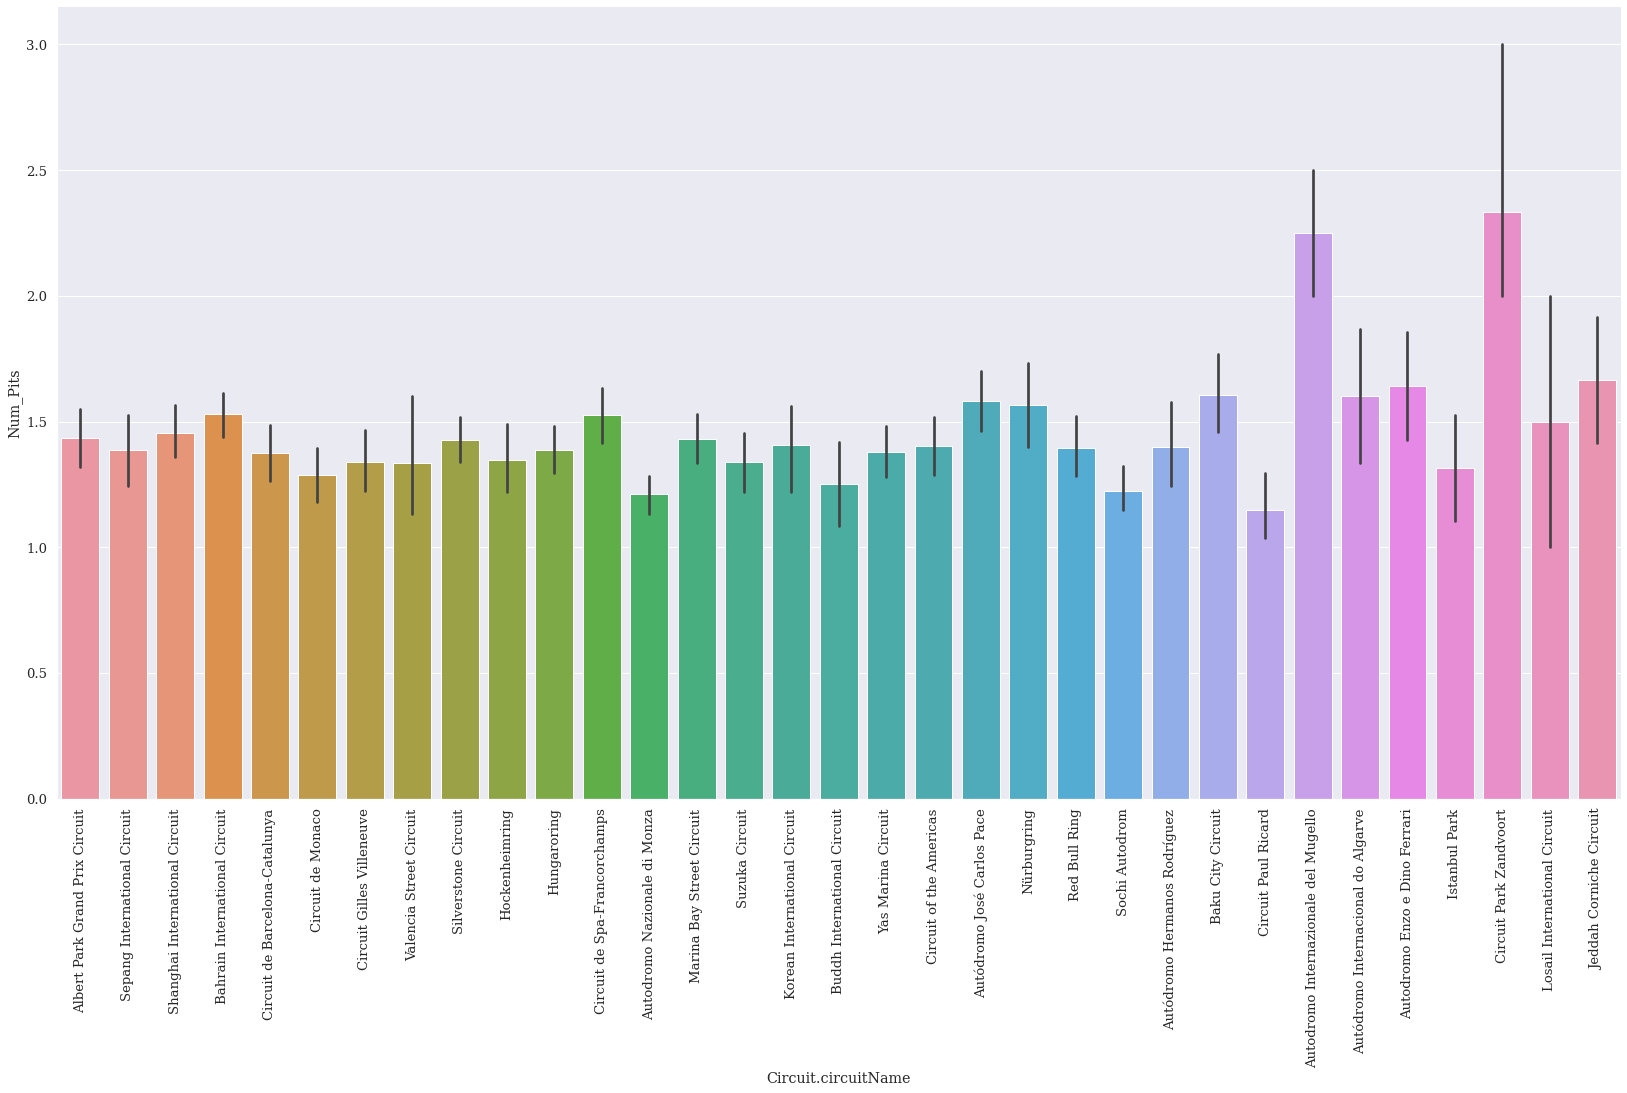

In [135]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="Circuit.circuitName", y="Num_Pits",kind="bar",height=12,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average numper of pit stops per year

The number of pit stops on average decreased in 2018. This might have been caused by several causes like changes in the regulations, different circuits in that season, etc.

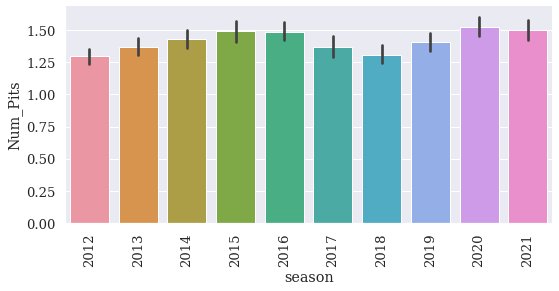

In [125]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="Num_Pits",kind="bar",height=4,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average number of laps between pit stops per circuit

We can see that contrary to what it was believed, the number of laps on average per pit stop have increased and decreased depending on each circuit.

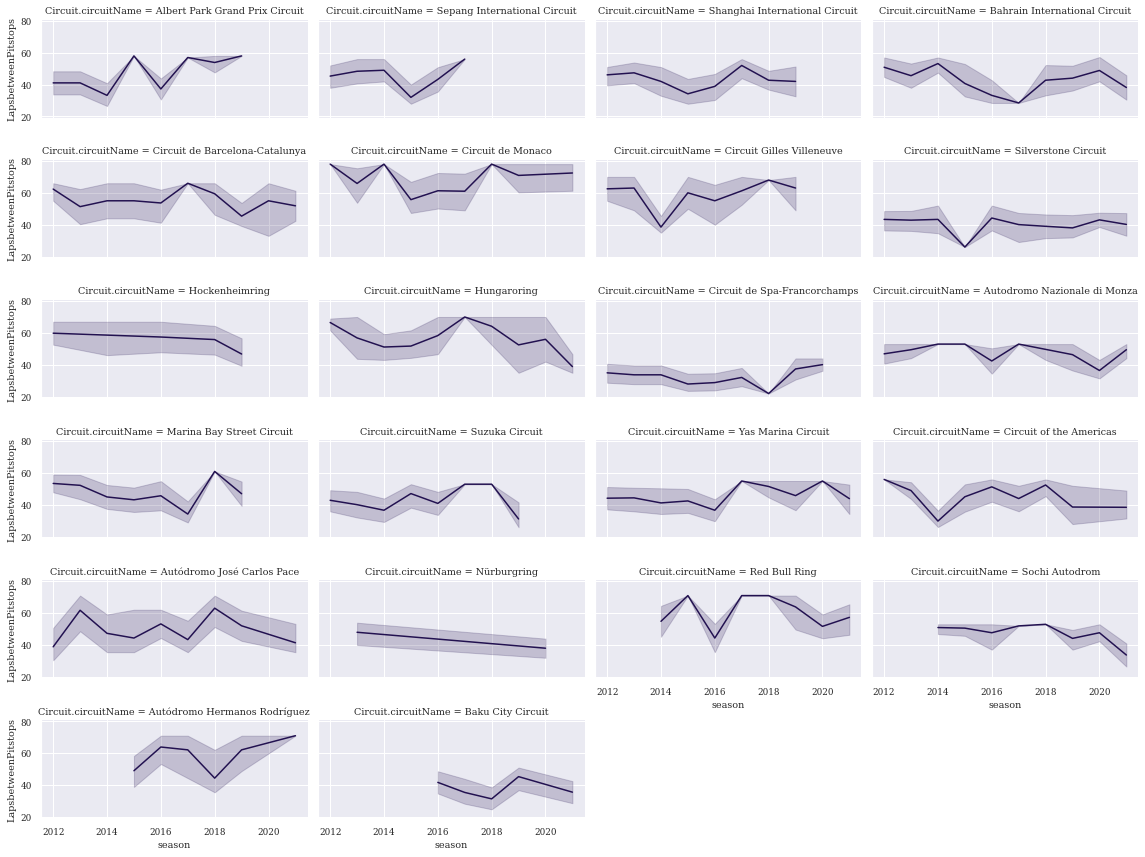

In [120]:
#Selecting specific circuits where at least two seasons a race has been helds=
SelectedCircuits=['albert_park', 'sepang', 'shanghai', 'bahrain', 'catalunya',
       'monaco', 'villeneuve', 'silverstone',
       'hockenheimring', 'hungaroring', 'spa', 'monza', 'marina_bay',
       'suzuka', 'yas_marina', 'americas',
       'interlagos', 'nurburgring', 'red_bull_ring', 'sochi', 'rodriguez',
       'BAK']

PitsUnified_Finished_Selected=PitsUnified_Finished[PitsUnified_Finished["Circuit.circuitId"].isin(SelectedCircuits) == True]

sns.set_theme(style="darkgrid", palette="magma",font_scale=0.8,font="serif")
sns.relplot(data=PitsUnified_Finished_Selected,x="season", y="LapsbetweenPitstops",col="Circuit.circuitName",col_wrap=4,kind="line",height=2,aspect=2)

### Average number of laps between pit stops

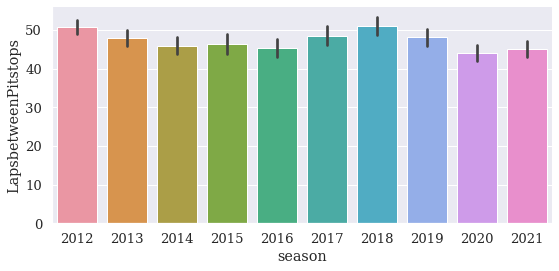

In [134]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="LapsbetweenPitstops",kind="bar",height=4,aspect=2)

### Encoding the categorical features

In [236]:
from sklearn.preprocessing import LabelEncoder

#Features to encode:
to_encode=['Season-Round-Driver', 'driverId', 'Circuit.circuitId','Circuit.Location.country', 'Constructor.constructorId']

for n in to_encode:
    encoder = LabelEncoder()
    encoder.fit(PitsUnified_Finished[n])
    nameencoded=n+"_enc"
    encoders=encoder.transform(PitsUnified_Finished[n])
    PitsUnified_Finished[nameencoded]=encoders

PitsUnified_Finished=PitsUnified_Finished.reset_index() #reset index of added features, if this is not done, there is an error later


### Relationship between features

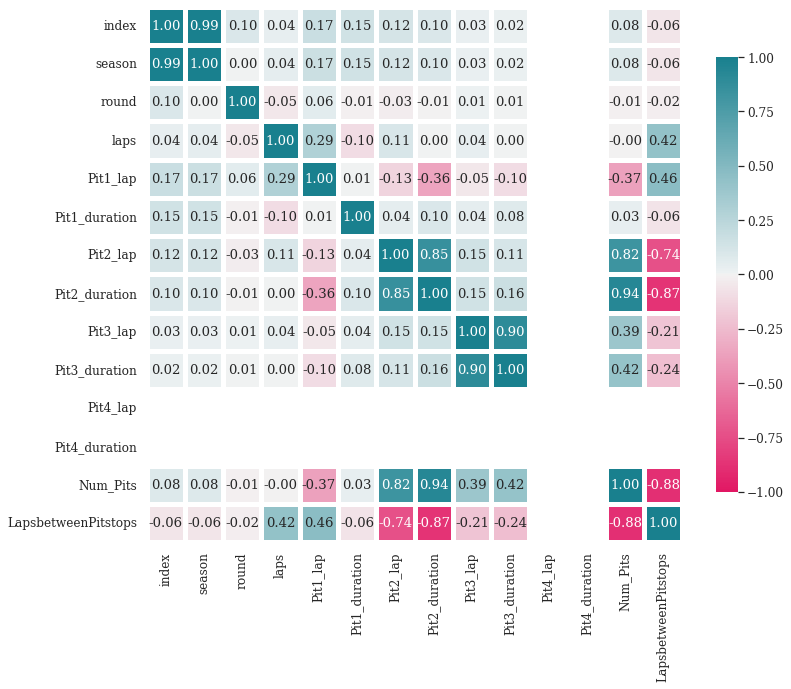

In [223]:
#Relationship between all the variables

#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.1,font="serif")
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(PitsUnified_Finished.corr(), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
plt.show()

### Before making predictions...

In [274]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix to evaluate results

from sklearn.model_selection import GridSearchCV #Hyperparameter optimization
from sklearn.model_selection import KFold #set kfold configuration
from sklearn.model_selection import cross_val_score #cross validation
from sklearn.metrics import make_scorer #set scores desired to train models
from sklearn.metrics import mean_squared_error

#Set scorers
f1_scorer=make_scorer(f1_score)
accuracy_scorer=make_scorer(accuracy_score)

### Function to test and evaluate the algorithms
def testing_the_classifier():
    Train=pd.DataFrame()
    Train["Predicted"]=y_train_predicted
    Train["Real"]=y_train.tolist()

    Test=pd.DataFrame()
    Test["Predicted"]=y_test_predicted
    Test["Real"]=y_test.tolist()

    #Generate the confusion matrixes

    cf_matrixtrain = confusion_matrix(Train["Real"], Train["Predicted"])
    cf_matrixtest = confusion_matrix(Test["Real"], Test["Predicted"])

    print("\n Training Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=(5,3))
    ax = sns.heatmap(cf_matrixtrain, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['1','2',"3"])
    ax.yaxis.set_ticklabels(['1','2',"3"])
    plt.show()

    print("Accuracy score:",accuracy_score(Train["Real"], Train["Predicted"])) #Ratio of correct predictions
    #print("F1 score:",f1_score(Train["Real"], Train["Predicted"])) #this is useful because we have imbalanced data
    print(Train.groupby(["Real","Predicted"]).count())

    print("\n Testing Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=(5,3))
    ax = sns.heatmap(cf_matrixtest, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['1','2',"3"])
    ax.yaxis.set_ticklabels(['1','2',"3"])
    plt.show()

    print("Accuracy score:",accuracy_score(Test["Real"], Test["Predicted"])) #Ratio of correct predictions
    #print("F1 score:",f1_score(Test["Real"], Test["Predicted"])) #this is useful because we have imbalanced data
    print(Test.groupby(["Real","Predicted"]).count())

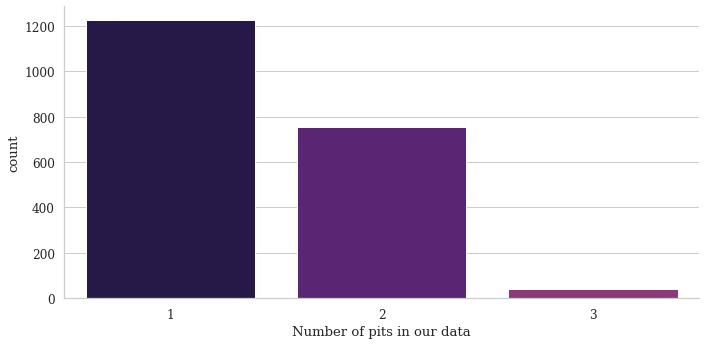

In [242]:
#Bar plot: class distribution
g=sns.catplot(x="Num_Pits",data=PitsUnified_Finished,kind="count",height=5,aspect=2)
g.set(xlabel="Number of pits in our data")
plt.show()

#There exists a class imbalance

In [257]:
len(PitsUnified_Finished[PitsUnified_Finished["Num_Pits"]==3]) #number of drivers-races with 3 pitstops

41

### Trying Random Forest Classifier to predict the feature "Num_Pits"

In [243]:
#PitsUnified_Finished.columns

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc',
       'Constructor.constructorId_enc']

selectednumber=1 #randomseed

In [245]:
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished["Num_Pits"], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)

In [277]:
from sklearn.ensemble import RandomForestClassifier

#Cross Validation using Grid Search
RF=RandomForestClassifier(random_state=selectednumber,n_estimators=100)
tuned_parameters = [{'criterion': ["gini","entropy"],"max_features":["auto","sqrt","log2",None]}]
for x in range(2,10):
    # clf = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
    # clf.fit(X_train, y_train)
    # print("Folds: ",x,"- F1 score: ",clf.best_score_," ",clf.best_params_)
    #in this case the f1 scorer was nan in every fold
    clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
    clf2.fit(X_train, y_train)
    print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

Folds:  2 - Accuracy:  0.5955418007808198   {'criterion': 'gini', 'max_features': 'auto'}
Folds:  3 - Accuracy:  0.6227581941867656   {'criterion': 'entropy', 'max_features': 'auto'}
Folds:  4 - Accuracy:  0.6041850018335168   {'criterion': 'gini', 'max_features': 'auto'}
Folds:  5 - Accuracy:  0.604204410809158   {'criterion': 'gini', 'max_features': None}
Folds:  6 - Accuracy:  0.6159484143375097   {'criterion': 'gini', 'max_features': 'auto'}
Folds:  7 - Accuracy:  0.6178107606679035   {'criterion': 'gini', 'max_features': 'auto'}
Folds:  8 - Accuracy:  0.6097552797151636   {'criterion': 'entropy', 'max_features': 'auto'}
Folds:  9 - Accuracy:  0.6209014414787226   {'criterion': 'gini', 'max_features': 'auto'}


0.0 - 0.4049382716049383
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       980
           2       1.00      1.00      1.00       604
           3       1.00      1.00      1.00        33

    accuracy                           1.00      1617
   macro avg       1.00      1.00      1.00      1617
weighted avg       1.00      1.00      1.00      1617


 Training Data:


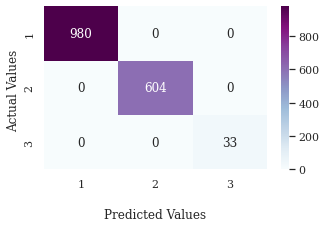

Accuracy score: 1.0
Empty DataFrame
Columns: []
Index: [(1, 1), (2, 2), (3, 3)]

 Testing Data:


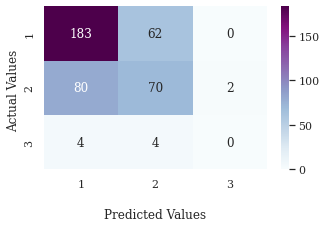

Accuracy score: 0.6246913580246913
Empty DataFrame
Columns: []
Index: [(1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)]
              precision    recall  f1-score   support

           1       0.69      0.75      0.71       245
           2       0.51      0.46      0.49       152
           3       0.00      0.00      0.00         8

    accuracy                           0.62       405
   macro avg       0.40      0.40      0.40       405
weighted avg       0.61      0.62      0.61       405



In [278]:
RF=RandomForestClassifier(n_estimators=100,random_state=selectednumber,criterion="gini",max_features="auto")
RF.fit(X_train, y_train)
y_train_predicted=RF.predict(X_train)
y_test_predicted=RF.predict(X_test)
np.unique(y_test_predicted)
mse_train = mean_squared_error(y_train,y_train_predicted)
mse_test = mean_squared_error(y_test,y_test_predicted)
print(mse_train,"-",mse_test)

print(classification_report(y_train, y_train_predicted))
testing_the_classifier()
print(classification_report(y_test, y_test_predicted))